In [ ]:
%%HTML
<!-- Make fonts readable at 1024x768 -->
<style>
.rendered_html { font-size:0.5em; }
</style>

In [1]:
# Imports and matplotlib configuration
import numpy as np
import scipy.signal
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib import animation, rcParams
from ipywidgets import interact, FloatSlider, IntSlider, SelectionSlider, Layout, Button, Output, Box
from IPython.display import display, Audio, HTML
import soundfile as sf

# Default options for matplotlib plots
rcParams['figure.dpi'] = 80
rcParams['font.size'] = 14
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['legend.framealpha'] = 0.5
rcParams['legend.fontsize'] = 'medium'
rcParams['figure.titlesize'] = 'medium'
rcParams['figure.autolayout'] = True
# rcParams['animation.html'] = 'html5'
slider_layout = Layout(width='600px', height='20px')
slider_style = {'description_width': 'initial'}
from functools import partial
FloatSlider_nice = partial(FloatSlider, style=slider_style, layout=slider_layout, continuous_update=False)
IntSlider_nice = partial(IntSlider, style=slider_style, layout=slider_layout, continuous_update=False)
SelectionSlider_nice = partial(SelectionSlider, style=slider_style, layout=slider_layout, continuous_update=False)

# Optional: Set options for slide theme and transition
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/phuijse/.jupyter/nbconfig/"
cm = BaseJSONConfigManager(config_dir=path)
cm.update('livereveal', {
    'theme': 'simple',
    'transition': 'fast',
    'start_slideshow_at': 'selected',
    'width': 1024,
    'height': 768,
    'scroll': True,
    'center': False
});

### Universidad Austral de Chile 
## INFO183: Análisis de sistemas lineales


# Unidad 2: Herramientas de análisis de señales

### Dr. Pablo Huijse, phuijse at inf dot uach dot cl 

### <a href="https://github.com/phuijse/UACH-INFO183"> github.com/phuijse/UACH-INFO183 </a>


# Contenidos de la unidad

1. [Representación por serie de Fourier](#section1)
1. Transformada de Fourier y sus propiedades
1. Principio de incertidumbre
1. Transformada de Fourier discreta (DFT) y sus propiedades
1. Efectos del muestreo y del enventanado
1. Transformada rápida de Fourier (FFT)
1. Espectrograma con Transformada de Fourier short-time
1. Detección y comparación de señales
1. Autocorrelación y correlación cruzada
1. Espectro de potencia y periodograma
1. Teorema de Wiener-Khinchin
1. Detección de señales con Match filter
1. Limpieza de señales con filtro de Wiener


<a id="section1"></a>

# Espectro

- Isaac Newton llamó **espectros** a los componentes que forman la luz blanca y que normalmente no se pueden ver
- Newton mostró usando prismas que la luz blanca pueden descomponerse en colores y viceverza
- Hoy entendemos que la luz como onda tiene una frecuencia asociada y que cada color es una frecuencia particular


| <img src="img/fourier-newton.jpg">  | <img src="img/fourier-prism.jpg" width="75%">  |
|:-:|:-:|

- Paradojicamente, Newton nunca acepto que esto se debía a la frecuencia de la radiación ya que creía en la teoría corpuscular de la luz


## Onda

- Es una perturbación que transporta energía a través del espacio
- Es una oscilación o vibración de un medio físico o campo
- Se describe (tipicamente) por su frecuencia (período), amplitud y desfase

**Onda electromagnética** 
- Oscilaciones en el campo eléctrico y magnético
- Transporta energía electromágnetica radiativa
- Dependiendo de su frecuencia se clasifican como:
<img src="img/fourier-colors.jpg">

## Componentes frecuenciales y harmónicos

- Una sinusoide es una función del tiempo completamente descrita por su amplitud $A$, frecuencia $f$ y fase $\phi$

$$
s(t) = A \cos (2 \pi f t + \phi)
$$

*Ejercicio:* Explique intuitivamente como estos parámetros afectan a $s(t)$ 

- El recíproco de la frecuencia es el período $P= \frac{1}{f}$
- Notemos que una señal que es períodica en $\frac{P}{k} ~ \forall k \in \mathbb{N}$ también lo es en $P$
- Llamamos a $f=1/P$ la **frecuencia fundamental**
- Llamamos a $f_k = kf = k/P ~~ \forall k \in \mathbb{N}$ el **k-esimo harmónico de $f$**

<IPython.core.display.Javascript object>


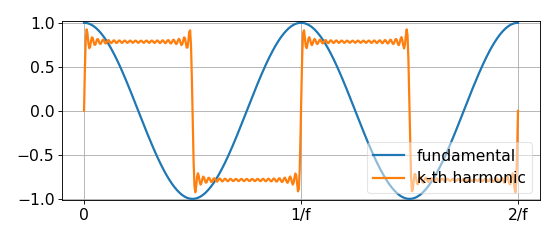

interactive(children=(SelectionSlider(continuous_update=False, description='k', layout=Layout(height='20px', w…

In [8]:
plt.close('all'); fig, ax = plt.subplots(figsize=(7, 3))
f = 1.51518
t = np.linspace(0, 2/f, num=500); x = np.cos(2.0*np.pi*f*t)
ax.plot(t, x, label='fundamental')
line = ax.plot(t, x, label='k-th harmonic'); ax.legend(loc=4)
ax.set_xticks([0, 1/f, 2/f]); ax.set_xticklabels(["0", "1/f", "2/f"]);
update = lambda k: line[0].set_ydata(np.cos(2.0*np.pi*t*f*k))
interact(update, k=SelectionSlider_nice(options=[2, 3, 4, 5, 6]));

- Si sumamos dos sinusoides con amplitudes arbitrarias pero con igual frecuencia fundamental $f$ [Hz], la suma también es periódica con fundamental $f$ [Hz]
- La suma puede ser una señal periódica arbitraria (no trigonométrica)

<IPython.core.display.Javascript object>


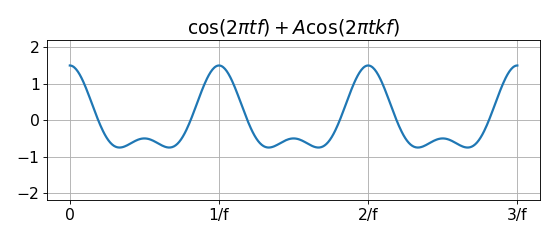

interactive(children=(SelectionSlider(continuous_update=False, description='k', layout=Layout(height='20px', w…

In [3]:
plt.close('all'); fig, ax = plt.subplots(figsize=(7, 3))
f = 1.51518
t = np.linspace(0, 3/f, num=500); x = np.cos(2.0*np.pi*f*t)
line = ax.plot(t, 2*x)
ax.set_xticks([0, 1/f, 2/f, 3/f]); ax.set_xticklabels(["0", "1/f", "2/f", "3/f"]);
ax.set_title(r"$\cos(2\pi t f) + A \cos(2\pi t k f)$")
update = lambda k, A: line[0].set_ydata(x + A*np.cos(2.0*np.pi*t*f*k))
interact(update, k=SelectionSlider_nice(options=[2, 3, 4, 5, 6]), 
         A=FloatSlider_nice(min=0.5, max=1.0, value=0.5));

- Dependiendo de los harmónicos que incorporemos podemos reproducir distintas señales periódicas

<IPython.core.display.Javascript object>


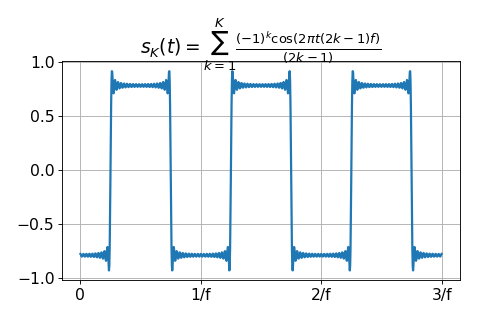

interactive(children=(SelectionSlider(continuous_update=False, description='K', layout=Layout(height='20px', w…

In [20]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 4))
f = 1.51518; t = np.linspace(0, 3/f, num=1000); 
line = ax.plot(t, np.zeros_like(t))
ax.set_xticks([0, 1/f, 2/f, 3/f]); ax.set_xticklabels(["0", "1/f", "2/f", "3/f"]);
ax.set_title(r"$s_K(t) = \sum_{k=1}^K \frac{(-1)^k \cos(2\pi t (2k-1) f)}{(2k-1)}$")
def update(K):
    y = np.zeros_like(t)
    for k in range(1, K+1):
        y += np.cos(2.0*np.pi*(2*k-1)*f*t)/(2*k-1)*(-1)**k
    line[0].set_ydata(y); ax.set_ylim([np.amin(y)*1.1, np.amax(y)*1.1])
interact(update, K=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 20, 30, 50, 100]));

<IPython.core.display.Javascript object>


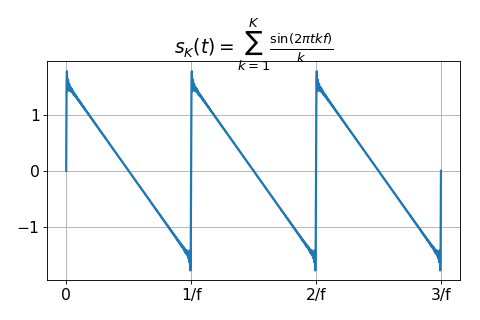

interactive(children=(SelectionSlider(continuous_update=False, description='K', layout=Layout(height='20px', w…

In [21]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 4))
f = 1.51518; t = np.linspace(0, 3/f, num=1000); 
line = ax.plot(t, np.zeros_like(t))
ax.set_xticks([0, 1/f, 2/f, 3/f]); ax.set_xticklabels(["0", "1/f", "2/f", "3/f"]);
ax.set_title(r"$s_K(t) = \sum_{k=1}^K \frac{\sin(2\pi t k f)}{k}$")
def update(K):
    y = np.zeros_like(t)
    for k in range(1, K+1):
        y += np.sin(2.0*np.pi*k*f*t)/k
    line[0].set_ydata(y); ax.set_ylim([np.amin(y)*1.1, np.amax(y)*1.1])
interact(update, K=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 20, 30, 50, 100]));

- Las funciones coseno y seno son par e impar, respectivamente
- ¿Cómo podemos construir una señal periódica que no es par ni impar?
- Consideremos la siguiente forma general
\begin{align}
s(t) &= \sum_{k=0}^\infty A_k \cos(2\pi k f t + \phi_k) \nonumber \\
&= \sum_{k=0}^\infty a_k \cos(2\pi k f t) + b_k \sin(2\pi k f t),
\end{align}
donde $a_k = A_k \cos(\phi_k)$ y $b_k = -A_k \sin(\phi_k)$ se obtienen de $\cos(x+y) = \cos(x)\cos(y) - \sin(x)\sin(y)$
- De esta forma $s(t)$ puede ser cualquier función real periódica
- Esto se conoce como **serie trigonométrica** 

<IPython.core.display.Javascript object>


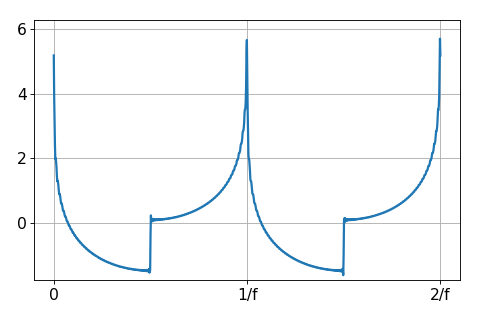

interactive(children=(SelectionSlider(continuous_update=False, description='K', layout=Layout(height='20px', w…

In [22]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 4))
f = 1.51518; t = np.linspace(0, 2/f, num=1000); 
line = ax.plot(t, np.zeros_like(t))
ax.set_xticks([0, 1/f, 2/f]); ax.set_xticklabels(["0", "1/f", "2/f"]);
def update(K):
    y = np.zeros_like(t)
    for k in range(1, K+1):
        y += np.cos(2.0*np.pi*k*f*t)/k - np.sin(2.0*np.pi*(2*k-1)*f*t)/(2*k-1)
    line[0].set_ydata(y); ax.set_ylim([np.amin(y)*1.1, np.amax(y)*1.1])
interact(update, K=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 20, 30, 50, 100]));

## Apéndice: Números complejos

Sea z un número complejo, lo podemos escribir en forma cartesiana 
$$
z = \Re[z] + j \Im[z] = a + j b
$$
donde $a \in \mathbb{R}$, $b \in \mathbb{R}$ y $j = \sqrt{-1}$ es el número imaginario.


También podemos escribirlo en forma polar
$$
z = c e^{j\phi} = c \cos(\phi) + j c \sin(\phi)
$$
donde 
- $c = |z| = \sqrt{a^2 + b^2} \in [0, \infty]$ es la magnitud 
- $\phi = \angle z = \tan^{-1} \left (\frac{b}{a} \right) \in [-\frac{\pi}{2}, \frac{\pi}{2}]$ es el ángulo
- $a = c \cos(\phi)$
- $b = c\sin(\phi)$

se pueden escribir las siguientes relaciones 

$$
\cos(\phi) = \frac{1}{2} (e^{j\phi} + e^{-j\phi}) ~\wedge~ \sin(\phi) = \frac{1}{2j} (e^{j\phi} - e^{-j\phi})
$$

el complejo conjugado de $z = a + j b = c e^{j\phi}$ es
$$
z^* = a - jb = c e^{-j\phi}
$$

# Serie de Fourier

- En 1807 *Jean Baptiste Joseph Fourier* presenta un teorema indicando que una función periódica arbitraria puede representarse como una suma ponderada de senos y cosenos
- La serie de Fourier (FS) para una función compleja se define como
$$
s(t) = \sum_{k=-\infty}^{\infty} c_k e^{j 2\pi kf t}, ~~ c_k \in \mathbb{C}
$$


La serie trigonométrica es el caso particular de la FS para una función real
\begin{align}
s(t) &= \sum_{k=-\infty}^{\infty} c_k e^{j 2\pi kf t} \nonumber \\
&= \sum_{k=1}^{\infty} c_{-k} e^{-j 2\pi kf t} + c_0 + \sum_{k=1}^{\infty} c_{k} e^{j 2\pi kf t} \\
&= \sum_{k=1}^{\infty} \left(c_{k} e^{j 2\pi kf t}\right)^* + c_0 + \sum_{k=1}^{\infty} c_{k} e^{j 2\pi kf t} \\
&= c_0 + 2 \sum_{k=1}^{\infty} \Re [ c_{k} e^{j 2\pi kf t} ]\\
&= \sum_{k=0}^{\infty} A_k \cos({j 2\pi kf t + \phi_k} )\\
\end{align}
en la última equivalencia reconocemos
$$
c_k = \begin{cases}  \frac{1}{2} A_k e^{j\phi_k} & k> 0 \\ A_0 & k = 0 \\ c_{|k|}* & k < 0\end{cases}
$$